# SEGMENTING AND CUSTERING NEIGBOURHOODS IN TORONTO

# PART 1: SCRAPING THE DATA AND TRANSFORMING TO PANDAS DATAFRAME

The dataframe is to be constructed according to the following specifications

- The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
- Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
- More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park.   These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
- If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
- Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
- In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

## FIRST INSTALL DEPENDENCIES (FOR WHOLE ASSIGNMENT)

In [56]:
#conda install -c conda-forge wordcloud==1.4.1 --yes
#!conda install -c conda-forge geocoder --yes
#!conda install -c conda-forge folium=0.5.0 --yes
!pip install beautifulsoup4
!pip install geocoder
!pip install folium==0.5.0
!pip install wordcloud==1.4.1
from wordcloud import WordCloud, STOPWORDS
import itertools
import pandas as pd # library for data analsysis
!pip install pandas==1.0.3 #In order to avoid json_normalize error
import numpy as np # library to handle data in a vectorized manner
import requests # library to handle requests
import geocoder # import geocoder
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup #library for pulling data out of HTML and XML files.
#from pandas.json import json_normalize
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

## NOW SCRAPE THE DESIRED DATA(TABLE) FROM THE SPECIFIED WIKIPEDIA PAGE
(https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)

In [2]:
req = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(req.content,'lxml')
table = soup.find_all('table')[0]
#Read HTML Table into List of Dataframe Objects
df = pd.read_html(str(table))

#### WARNING!! THIS CELL SOMETIMES PRODUCES ERROR (CANNOT IMPORT NAME 'url'). PLEASE RESTART KERNEL AND CLEAR OTPUTS AND TRY AGAIN IF THAT HAPPENS.

In [3]:
Neighbourhood=pd.DataFrame(df[0])
Neighbourhood.head(10)

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


## DROP ROWS WHERE BOROUGH "Not assigned'

### DETERMINE HOW MANY ROWS/CASES WILL BE DROPPED FROM DATASET

In [4]:
Neighbourhood['Borough'].value_counts()

#Ignore the following line. Including it for my own future reference.

#Neighbourhood[(Neighbourhood['Neighbourhood'] == 'Not assigned') & (Neighbourhood['Borough'] != 'Not assigned')]

Not assigned        77
North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East York            5
East Toronto         5
Mississauga          1
Name: Borough, dtype: int64

### WE SEE WE NEED TO DROP 77 ROWS/CASES FOR WHICH A BOROUGH IS NOT ASSIGNED AND ARE TO BE REMOVED

In [5]:
Neighbourhood = Neighbourhood[Neighbourhood['Borough'] != 'Not assigned']
Neighbourhood.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### RESET INDEX FOR PROPER INDEX CHRONOLOGY

In [6]:
Neighbourhood = Neighbourhood.reset_index(drop = True)
Neighbourhood.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### CHECK AND CONFIRM 'Not assigned' NO LONGER PRESENT IN 'Borough' FEATURE

In [7]:
Neighbourhood['Borough'].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East Toronto         5
East York            5
Mississauga          1
Name: Borough, dtype: int64

## NOW USE .shape() TO PRINT THE NUMBER OF ROWS IN THE DATAFRAME

In [8]:
print(Neighbourhood.shape[0])

103


# PART 2: GETTING THE COORDINATES AND APPENDING TO OUR DF

(DEPENDENCIES ALREADY INSTALLED/IMPORTED IN FIRST CELL OF NOTEBOOK)

## COULD NOT GET GEOCODER TO WORK (SEE REFERENCE CODE AT END). GET AND READ COORDINATE CSV

### GET COORDINATE CSV AND STORE AS TO_Coord

In [9]:
!wget -O TO_Coord.csv https://cocl.us/Geospatial_data

--2020-08-20 16:43:48--  https://cocl.us/Geospatial_data
Resolving cocl.us (cocl.us)... 169.55.161.7
Connecting to cocl.us (cocl.us)|169.55.161.7|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-08-20 16:43:49--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 107.152.26.197
Connecting to ibm.box.com (ibm.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-08-20 16:43:49--  https://ibm.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-08-20 16:4

### NOW READ CSV FILE AND TRANSFORM TO PD DATAFRAME 'Coord'

In [10]:
Coord = pd.read_csv('TO_Coord.csv')
Coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## CHECK TO MAKE SURE Coord DF DIMENSIONS ARE IDENTICAL TO Neighourhood DF

In [11]:
np.shape(Coord)

(103, 3)

## NOW MERGE Neighbourhood DF WITH Coord DF ON Postal Code
(USE .merge() FUNCTION AND MERGE ON COLUMN 'Postal Code')

In [12]:
Neighbourhood = Neighbourhood.merge(Coord, on = 'Postal Code')
Neighbourhood.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# PART 3: CLUSTERING AND EXPLORING TORONTO NEIGHBOURHOODS

# DEFINE PERSONAL FOURSQUARE APP CREDENTIALS AND VERSION. ALSO DEFINE TORONTO COORDINATES
(Toronto Coordinates (43.6532, -79.3832))

In [13]:
#Foursquare Creds
CLIENT_ID = 'GYHPVGUS1PFWT3WWAJ15JNODADMLQQX10FRJZJRIKJWGNL40' # your Foursquare ID
CLIENT_SECRET = 'Y40B3IL3W11SP13KGNDCNKMSHO1YI50WSE5MLOIVKHBJ5JLU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API versionT

#Toronto coordinates
TO_LAT = 43.6532
TO_LONG = -79.3832

## CREATE TORONTO MAP OBJECT AND DISPLAY IT

In [14]:
TO_Map = folium.Map(location=[TO_LAT, TO_LONG], zoom_start=11)
TO_Map

## NOW ADD MARKERS FOR EACH OF THE NEIGHBOURHOODS IN OUR 'Nighbourhood' DF TO THE MAP AND DISPLAY MAP

In [15]:
for lat, lng, borough, neighbourhood, PC in zip(Neighbourhood['Latitude'], Neighbourhood['Longitude'], Neighbourhood['Borough'], Neighbourhood['Neighbourhood'], Neighbourhood['Postal Code']):
    label = '{}, {}, {}'.format(neighbourhood, borough, PC)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(TO_Map)

TO_Map

## LETS TAKE A CLOSER LOOK AT THE NEIGHBOURHOOD OF CHRISTIE IN THE BOROUGH OF DOWNTOWN TORONTO

### FIRST LETS FILTER OUT A NEW DF CONTAINING ONLY THE NEIGHBOURHOOD OF CHRISTIE AND IT'S CORRESPONDING DATA

In [16]:
Christie = Neighbourhood[(Neighbourhood['Neighbourhood'] == 'Christie')]
Christie

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564


### NOW GET THE COORDINATES OF THE NEIGHBOURHOOD TO PASS IN THE QUERY URL TO THE FOURSQUARE API. ALSO STORE NEIGHBOURHOOD TO VARIABLE FOR EASIER CALLS TO API. DEFINE LIMIT AND RADIUS FOR API CALL AS WELL

In [17]:
#Define Coordinates
HOOD_LAT = Neighbourhood.loc[25, 'Latitude'] # neighborhood latitude value
HOOD_LONG = Neighbourhood.loc[25, 'Longitude'] # neighborhood longitude value

#Define search radius and the limit for results
LIMIT = 50
RADIUS = 500

### NOW WE CAN CONSTRUCT THE URL USED TO MAKE A CALL TO THE FOURSQUARE PLACES API. LETS LOOK AT THE TOP 50 VENUES IN THE NEIGHBOURHOOD WITH A SEARCH RADIUS OF 500M
(This means utilizing the GET method alongside the VENUES group and the SEARCH endpoint)

In [18]:
#Now construct the url needed to make the call to the Foursquare API
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    HOOD_LAT, 
    HOOD_LONG, 
    RADIUS, 
    LIMIT)

#Display the url
url

'https://api.foursquare.com/v2/venues/explore?&client_id=GYHPVGUS1PFWT3WWAJ15JNODADMLQQX10FRJZJRIKJWGNL40&client_secret=Y40B3IL3W11SP13KGNDCNKMSHO1YI50WSE5MLOIVKHBJ5JLU&v=20180605&ll=43.669542,-79.4225637&radius=500&limit=50'

### NOW SEND THE GET REQUEST AND EXAMINE THE RESULTS

In [19]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f3ea5f4474df22956dc568b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Christie Pits',
  'headerFullLocation': 'Christie Pits, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 16,
  'suggestedBounds': {'ne': {'lat': 43.6740420045, 'lng': -79.41635411972038},
   'sw': {'lat': 43.6650419955, 'lng': -79.42877328027961}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcfd7cf964a5203e6321e3',
       'name': 'Fiesta Farms',
       'location': {'address': '200 Christie St',
        'crossStreet': 'at Essex St',
        'lat': 43.66847077052224,
        'lng': -79.42048512748114,
        'labeledLatLngs': [{'label': 'd

### GET RELEVANT PART OF JSON FILE AND TRANSFORM TO A PANDAS DF Christie_Top50_DF

In [20]:
# assign relevant part of JSON to venues
venues = results['response']['groups'][0]['items']

# tranform venues into a dataframe
Christie_Top50_DF = pd.json_normalize(venues) #Flatten JSON
Christie_Top50_DF.head()

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,...,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,e-0-4adcfd7cf964a5203e6321e3-0,0,"[{'summary': 'This spot is popular', 'type': '...",4adcfd7cf964a5203e6321e3,Fiesta Farms,200 Christie St,at Essex St,43.668471,-79.420485,"[{'label': 'display', 'lat': 43.66847077052224...",...,M6G 3B6,CA,Toronto,ON,Canada,"[200 Christie St (at Essex St), Toronto ON M6G...","[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",0,[],56848730
1,e-0-540c8301498e51456f71ae7e-1,0,"[{'summary': 'This spot is popular', 'type': '...",540c8301498e51456f71ae7e,Contra Cafe,1028 Shaw St,Yarmouth,43.669107,-79.426105,"[{'label': 'display', 'lat': 43.66910714407297...",...,NaN,CA,Toronto,ON,Canada,"[1028 Shaw St (Yarmouth), Toronto ON, Canada]","[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",0,[],NaN
2,e-0-4dc9d2add4c07b350108956a-2,0,"[{'summary': 'This spot is popular', 'type': '...",4dc9d2add4c07b350108956a,Starbucks,657 Dupont St,at Christie St.,43.671530,-79.421400,"[{'label': 'display', 'lat': 43.67153, 'lng': ...",...,M6G 1Z4,CA,Toronto,ON,Canada,"[657 Dupont St (at Christie St.), Toronto ON M...","[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",0,[],NaN
3,e-0-4b003cf6f964a520d73b22e3-3,0,"[{'summary': 'This spot is popular', 'type': '...",4b003cf6f964a520d73b22e3,Vinny’s Panini,787 Dupont Street,NaN,43.670679,-79.426148,"[{'label': 'display', 'lat': 43.67067884412717...",...,M6G 1Z5,CA,Toronto,ON,Canada,"[787 Dupont Street, Toronto ON M6G 1Z5, Canada]","[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",0,[],NaN
4,e-0-536e42af498e8a0880b220d7-4,0,"[{'summary': 'This spot is popular', 'type': '...",536e42af498e8a0880b220d7,Scout and Cash Caffe,146 Christie Street,Bloor,43.667360,-79.419938,"[{'label': 'display', 'lat': 43.66735987720157...",...,M6G 3B3,CA,Toronto,ON,Canada,"[146 Christie Street (Bloor), Toronto ON M6G 3...","[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",0,[],85621950


### NOW DEFINE THE Get_Category_Type FUNCTION FROM THE FOURSQUARE LAB TO BE USED FOR FILTERING THE DATAFRAME

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### NOW PASS Christie_Top50_DF AS THE FUNCTION ARGUMENT (row) TO FILTER THE DF

In [22]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
Christie_Top50_DF = Christie_Top50_DF.loc[:, filtered_columns]

# filter the category for each row
Christie_Top50_DF['venue.categories'] = Christie_Top50_DF.apply(get_category_type, axis=1)

# clean columns
Christie_Top50_DF.columns = [col.split(".")[-1] for col in Christie_Top50_DF.columns]

Christie_Top50_DF.head()

,name,categories,lat,lng
0,Fiesta Farms,Grocery Store,43.668471,-79.420485
1,Contra Cafe,Café,43.669107,-79.426105
2,Starbucks,Coffee Shop,43.671530,-79.421400
3,Vinny’s Panini,Italian Restaurant,43.670679,-79.426148
4,Scout and Cash Caffe,Café,43.667360,-79.419938


### GET THE DIMENSIONS OF THE RESULTING DF
We can see that there weren't enough venues in the neighbourhood to warrant the LIMIT of 50. There are only 17 venues returned within given radius of 500m)

In [23]:
Christie_Top50_DF.shape

(16, 4)

### WHAT SORTS OF VENUES ARE IN THE NEIGHBOURHOOD?

In [24]:
Christie_Top50_DF['categories'].value_counts()

Grocery Store         4
Café                  3
Park                  2
Restaurant            1
Coffee Shop           1
Diner                 1
Italian Restaurant    1
Candy Store           1
Baby Store            1
Nightclub             1
Name: categories, dtype: int64

## NOW LETS EXPLORE ALL OF THE NEIGHBOURHOODS IN THE DOWNTOWN BOROUGH OF TORONTO

### FIRST CREATE A DF SPECIFC TO DOWNTOWN TORONTO BY SLICING OUR Neighbourhood DF TO FORM DT_TO DF

In [25]:
DT_TO = Neighbourhood[Neighbourhood['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
DT_TO

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
8,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752
9,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576


### GET THE COORDINATES OF DOWNTOWN TORONTO USING GEOPY GEOLOCATOR

In [26]:
address = 'Downtown Toronto, TO'

geolocator = Nominatim(user_agent="TO_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Downtown Toronto are 43.6541737, -79.38081164513409.


### NOW CREATE A MAP OBJECT FOR DOWNTOWN TORONTO AND DISPLAY MAP

In [27]:
# create map of Downtown Toronto using latitude and longitude values
map_DT_TO = folium.Map(location=[latitude, longitude], zoom_start=14)
map_DT_TO

### NOW PLACE MARKERS IDENTIFYING THE DIFFERENT NEIGHBOURHOODS CONTAINED IN DOWNTOWN TORONTO AND DISPLAY MAP

In [28]:
# add markers to map
for lat, lng, borough, neighborhood, PC in zip(DT_TO['Latitude'],  DT_TO['Longitude'],  DT_TO['Borough'],  DT_TO['Neighbourhood'], DT_TO['Postal Code']):
    label = '{}, {}, {}'.format(neighborhood, borough, PC)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_DT_TO)  
    
map_DT_TO

### CHRISTIE SEEMED LIKE A NICE ENOUGH NEIGHBOURHOOD, BUT LETS TAKE A LOOK AT ALL THAT DOWNTOWN TORONTO HAS TO OFFER BY CREATING AND EXECUTING A FUNCTION TO GET ALL OF THE VENUES FOR DOWNTOWN.

In [29]:
LIMIT = 1000

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### NOW CALL THE ABOVE FUNCTION USING THE DT_TO DF AND CREATE A NEW DF CALLED DT_TO_Venues

In [31]:
DT_TO_Venues = getNearbyVenues(names =  DT_TO['Neighbourhood'],
                               latitudes =  DT_TO['Latitude'],
                               longitudes =  DT_TO['Longitude']
                              )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


### LETS TAKE A LOOK AT THE RESULTING DF

In [32]:
DT_TO_Venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


### WHAT ARE THE DIMENSIONS OF THE RESULTING DF?
We see below that it contains 1,245 rows and 7 columns meaning there are 1,245 Venues collected for the Downtown Toronto

In [33]:
DT_TO_Venues.shape

(1248, 7)

### HOW MANY VENUES ARE IN EACH NEIGHBOURHOOD IN DOWNTOWN TORONTO
(Determine this using the .groupby() and .count() methods)

In [34]:
DT_TO_Venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,57,57,57,57,57,57
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,63,63,63,63,63,63
Christie,16,16,16,16,16,16
Church and Wellesley,76,76,76,76,76,76
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
"First Canadian Place, Underground city",100,100,100,100,100,100
"Garden District, Ryerson",100,100,100,100,100,100
"Harbourfront East, Union Station, Toronto Islands",100,100,100,100,100,100


### Let's find out how many unique categories can be curated from all the returned venues

In [35]:
print('There are {} uniques categories.'.format(len(DT_TO_Venues['Venue Category'].unique())))

There are 207 uniques categories.


## NOW WE CAN ANALYZE EACH NEIGHBOURHOOD

### TRANSFORM DF USING ONE HOT ENCODING TO GET DUMMY VARIABLES

In [36]:
# one hot encoding
DT_TO_onehot = pd.get_dummies(DT_TO_Venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
DT_TO_onehot['Neighbourhood'] = DT_TO_Venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [DT_TO_onehot.columns[-1]] + list(DT_TO_onehot.columns[:-1])
DT_TO_onehot = DT_TO_onehot[fixed_columns]

DT_TO_onehot.head()

,Neighbourhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### WHAT ARE THE DIMENSIONS OF THE ENCODED DF?
As we can see, the encoded DF has the same dimensions as the Downtown Toronto Venues DF

In [37]:
DT_TO_onehot.shape

(1248, 208)

### Next, let's group rows by neighborhood and take the mean of the frequency of occurrence of each category


In [38]:
DT_TO_grouped = DT_TO_onehot.groupby('Neighbourhood').mean().reset_index()
DT_TO_grouped

,Neighbourhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.017544,0.000000,0.000000,0.000000,0.00,0.000000
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.058824,0.058824,0.058824,0.058824,0.176471,0.117647,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.015873,0.000000,0.000000,0.015873,0.00,0.015873
3,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,Church and Wellesley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013158,0.000000,0.00,...,0.013158,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.026316
5,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.020000,0.000000,0.000000,0.010000,0.00,0.000000
6,"First Canadian Place, Underground city",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.00,...,0.000000,0.00,0.00,0.01,0.010000,0.000000,0.000000,0.010000,0.00,0.000000
7,"Garden District, Ryerson",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.01,0.00,0.00,0.000000,0.010000,0.010000,0.010000,0.00,0.000000
8,"Harbourfront East, Union Station, Toronto Islands",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.05,...,0.000000,0.00,0.00,0.01,0.010000,0.000000,0.000000,0.010000,0.00,0.000000
9,"Kensington Market, Chinatown, Grange Park",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.044118,0.000000,0.044118,0.014706,0.00,0.000000


### Let's print each neighborhood along with the top 10 most common venues

In [39]:
num_top_venues = 10

for hood in DT_TO_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = DT_TO_grouped[DT_TO_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1              Bakery  0.04
2      Farmers Market  0.04
3                Café  0.04
4            Beer Bar  0.04
5         Cheese Shop  0.04
6  Seafood Restaurant  0.04
7          Restaurant  0.04
8        Cocktail Bar  0.04
9           Jazz Club  0.02


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0      Airport Service  0.18
1     Airport Terminal  0.12
2              Airport  0.06
3      Harbor / Marina  0.06
4  Rental Car Location  0.06
5          Coffee Shop  0.06
6     Sculpture Garden  0.06
7                Plane  0.06
8        Boat or Ferry  0.06
9                  Bar  0.06


----Central Bay Street----
                 venue  freq
0          Coffee Shop  0.17
1                 Café  0.05
2   Italian Restaurant  0.05
3       Sandwich Place  0.05
4          Salad Place  0.03
5      Bubble Tea Shop  0.03
6  J

### NOW TRANSFORM THE ABOVE TO A PANDAS DF

#### FIRST CREATE FUNCTION TO SORT THE ABOVE IN DESCENDING ORDER

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = DT_TO_grouped['Neighbourhood']

for ind in np.arange(DT_TO_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(DT_TO_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cheese Shop,Cocktail Bar,Bakery,Café,Beer Bar,Seafood Restaurant,Farmers Market,Restaurant,Beach
1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport,Bar,Plane,Rental Car Location,Sculpture Garden,Boutique,Boat or Ferry,Coffee Shop
2,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint,Japanese Restaurant,Salad Place,Bubble Tea Shop,Poke Place,Portuguese Restaurant
3,Christie,Grocery Store,Café,Park,Italian Restaurant,Candy Store,Coffee Shop,Diner,Nightclub,Baby Store,Restaurant
4,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Café,Men's Store,Mediterranean Restaurant,Hotel,Yoga Studio
5,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Restaurant,Hotel,Gym,American Restaurant,Japanese Restaurant,Seafood Restaurant,Italian Restaurant,Bar
6,"First Canadian Place, Underground city",Coffee Shop,Café,Hotel,Restaurant,Gym,Japanese Restaurant,Salad Place,Seafood Restaurant,Asian Restaurant,Steakhouse
7,"Garden District, Ryerson",Clothing Store,Coffee Shop,Café,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Electronics Store,Lingerie Store,Italian Restaurant,Middle Eastern Restaurant
8,"Harbourfront East, Union Station, Toronto Islands",Coffee Shop,Aquarium,Restaurant,Café,Hotel,Fried Chicken Joint,Italian Restaurant,Brewery,Scenic Lookout,Sporting Goods Shop
9,"Kensington Market, Chinatown, Grange Park",Café,Coffee Shop,Mexican Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Park,Caribbean Restaurant,Dumpling Restaurant,Burger Joint,Bar


#### WITH THE ABOVE DF WE CAN SEE WHICH NEIGHBOURHOODS HAVE AN ABUNDANCE (OR LACK OF) DIFFERENT TYPES OF VENUES. AS ONE WOULD EXPECT FOR A DOWNTOWN CORE OF A CITY IT IS PACKED WITH COFFEE SHOPS/CAFES , RESTAURAUNTS AND BARS. 

## NOW TIME TO CLUSTER THE NEIGHBOURHOODS USING K-MEANS

### BUILD K-MEANS MODEL SETTING K=5 TO OBTAIN 5 CLUSTERS

In [42]:
# set number of clusters
k = 5

DT_TO_grouped_clustering = DT_TO_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(DT_TO_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 4, 2, 1, 1, 1, 1, 1, 1], dtype=int32)

### CREATE A NEW DF THAT INCLUDES THE CLUSTER THAT THE GIVEN NEIGHBOURHOOD BELONGS TO

In [43]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [44]:
DT_TO_merged = DT_TO

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
DT_TO_merged = DT_TO_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

DT_TO_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Café,Pub,Bakery,Park,Breakfast Spot,Restaurant,Theater,Dessert Shop,Chocolate Shop
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4,Coffee Shop,Yoga Studio,Sandwich Place,Smoothie Shop,Italian Restaurant,Diner,Portuguese Restaurant,Chinese Restaurant,Bar,Bank
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Clothing Store,Coffee Shop,Café,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Electronics Store,Lingerie Store,Italian Restaurant,Middle Eastern Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Cocktail Bar,Restaurant,American Restaurant,Seafood Restaurant,Hotel,Beer Bar,Farmers Market,Italian Restaurant
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Coffee Shop,Cheese Shop,Cocktail Bar,Bakery,Café,Beer Bar,Seafood Restaurant,Farmers Market,Restaurant,Beach


In [45]:
DT_TO_merged

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Café,Pub,Bakery,Park,Breakfast Spot,Restaurant,Theater,Dessert Shop,Chocolate Shop
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4,Coffee Shop,Yoga Studio,Sandwich Place,Smoothie Shop,Italian Restaurant,Diner,Portuguese Restaurant,Chinese Restaurant,Bar,Bank
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Clothing Store,Coffee Shop,Café,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Electronics Store,Lingerie Store,Italian Restaurant,Middle Eastern Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Cocktail Bar,Restaurant,American Restaurant,Seafood Restaurant,Hotel,Beer Bar,Farmers Market,Italian Restaurant
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Coffee Shop,Cheese Shop,Cocktail Bar,Bakery,Café,Beer Bar,Seafood Restaurant,Farmers Market,Restaurant,Beach
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,4,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint,Japanese Restaurant,Salad Place,Bubble Tea Shop,Poke Place,Portuguese Restaurant
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564,2,Grocery Store,Café,Park,Italian Restaurant,Candy Store,Coffee Shop,Diner,Nightclub,Baby Store,Restaurant
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,1,Coffee Shop,Café,Hotel,Restaurant,Clothing Store,Gym,Bar,Steakhouse,Thai Restaurant,Office
8,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,1,Coffee Shop,Aquarium,Restaurant,Café,Hotel,Fried Chicken Joint,Italian Restaurant,Brewery,Scenic Lookout,Sporting Goods Shop
9,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,1,Coffee Shop,Hotel,Café,Restaurant,American Restaurant,Salad Place,Italian Restaurant,Japanese Restaurant,Seafood Restaurant,Bar


#### IN HINDSIGHT I REALIZE THAT I LIKELY SHOULD HAVE ANALYZED ALL OF THE NEIGHBOURHOODS IN TORONTO, OR AT LEAST SOME SORT OF LARGER SUBSET NOT LIMItED to the DOWNTOWN AREA OF THE CITY. THERE WEREN'T MANY NEIGHBOURHOODS TO WORK WITH AND SO IT"S DIFFICULT TO GET GOOD CLUSTERS. PLEASE NOTE, HOWEVER, THAT THE ASSIGNMENT STATES THAT IT IS UP TO US AS TO HOW/WHICH NEIGHBOURHOODS WE CLUSTER SO THIS SHOULD NOT BE SOMETHING THAT IMPACTS MY MARK.

### NOW VISUALIZE THE RESULTING CLUSTERS

In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(DT_TO_merged['Latitude'], DT_TO_merged['Longitude'], DT_TO_merged['Neighbourhood'], DT_TO_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### AS WE CAN SEE MORE CLEARLY FROM THE MAPE THAN WE CAN FROM THE DATAFRAME, THERE ARE 3 OUTLIER CLUSTERS CONTAINING ONLY ONE NEIGHBOURHOOD EACH. THE REASON FOR THIS IS OBVIOUS IN THE CASE OF THE AIRPORT/RAILWAY LANDS. THIS REGION WOULD BE HEAVILY INDUSTRIAL/LOGISTICAL AND WOULD STAND OUT AMONG THE COMPARATIVELY METROPOLITAN NEIGHBOURHOODS THAT COMPRISE THE BULK OF THE DOWNTOWN NEIGHBOURHOODS.
#### THE SAME APPLIES TO THE ROSEDALE CLUSTER IN THE TOP RIGHT CORNER IN THAT (AS WE CAN SEE FROM THE MAP) IT IS VERY GEOGRAPHICALLY AND FUNCTIONALLY DISTINCT FROM THE OTHER DOWNTOWN NEIGHBOURHOODS. IT RESIDES ALONGSIDE A LOT OF GREEN SPACE AND A RIVER AND SO NATURALLY IT DEVIATES FROM OTHER DOWNTOWN NEIGHBOURHOODS DUE TO IT'S ABUNDANCE OF PARKS/TRAILS/DOG RUNS. IT IS MORE CENTERED AROUND RECREATION WHICH IS NOT SOMETHING SHARED BY ThE OTHER NEIGHBOURHOODS AND SO, LIKE THE AIRPORT NEIGHBOURHOOD, IT BECOMES RELEGATED TO ITS OWN CLUSTER WITH IT'S OWN CENTROID.

## ANALYZE EACH CLUSTER

#### CREAT stopwords VARIABLE FOR WORDCLOUDS

In [50]:
stopwords = set(STOPWORDS)

### FIRST WE BREAK THE CLUSTERS DOWN INTO INDIVIDUAL DATAFRAMES CONTAINING THEIR RESPECTIVE NEIGHBOURHOODS

### CLUSTER #1: Parks and Recreation Cluster
This cluster pertains to the outlier that is the Neighborhood of Rosedale (Red) in the top right. It was already discussed as to why Rosedale stands out as an outlier and why it received it's own cluster. We'll dome analysis anyway to cement these points.
As is the case for several clusters in this analysis, the descriptive stats and the Word Cloud aren't all that useful given the solitary neighbourhood in the cluster, however, they are performed for the purposes of consistency and practice.

In [47]:
CLUSTER_1 = DT_TO_merged.loc[DT_TO_merged['Cluster Labels'] == 0, DT_TO_merged.columns[[1] + list(range(5, DT_TO_merged.shape[1]))]]
CLUSTER_1

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Downtown Toronto,0,Park,Playground,Trail,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


#### GATHER DESCRIPTIVE STATS INCLUDING CATEGORICAL VALUES FOR THE CLUSTER

In [48]:
CLUSTER_1.describe(include = 'all')

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,1,1.0,1,1,1,1,1,1,1,1,1,1
unique,1,NaN,1,1,1,1,1,1,1,1,1,1
top,Downtown Toronto,NaN,Park,Playground,Trail,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
freq,1,NaN,1,1,1,1,1,1,1,1,1,1
mean,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### VISUALIZE CLUSTER WITH A WORD CLOUD 

In [54]:
CLUSTER_1_TEXT = CLUSTER_1.values.tolist()
CLUSTER_1_TEXT

[['Downtown Toronto',
  0,
  'Park',
  'Playground',
  'Trail',
  'Yoga Studio',
  'Dessert Shop',
  'Electronics Store',
  'Eastern European Restaurant',
  'Dumpling Restaurant',
  'Donut Shop',
  'Doner Restaurant']]

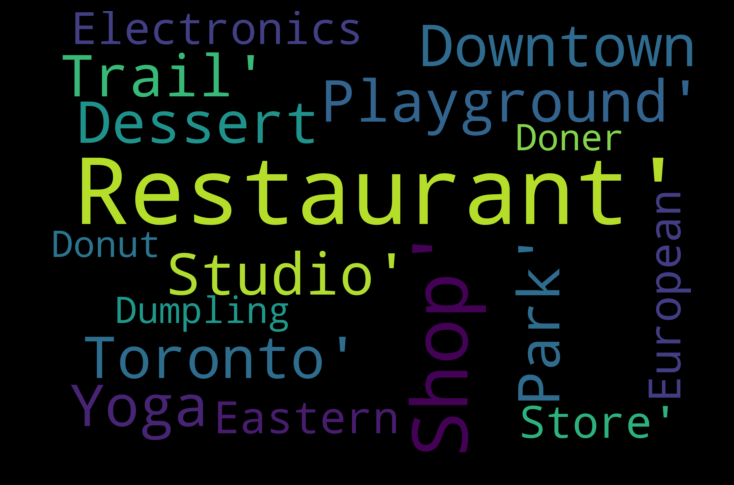

In [59]:
text = CLUSTER_1_TEXT
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### CLUSTER #2: The Metro Cluster
This cluster is titled as such since it appears geared towards exactly what one could typically expect the downtown core of a major metropolitan city would be; that being dining, socializing, nightlife, and the Metropolitan experience. Coffee shops/Cafes, Restaurants, eateries, and bars dominate the most common values for the cluster across all 14 of it's constituent neighbourhoods. It's to be expected given there close geographic proximity to each other situated in the heart of Toronto's dowtown core. This is strongly evidenced as well by the descriptive statistics table which shows that, the trend above is broken only once for the 6th most common value, but with a frequency of only 2. The Word Cloud also supports this conclusion. It is far more diverse than that for the other neighbourhoods, but mostly highlights venues associated with food and nightlife, breaking the trend occasionally to highlight the sort of boutiques one would expect owntown such as 'Lingerie' venues. 

In [61]:
CLUSTER_2 = DT_TO_merged.loc[DT_TO_merged['Cluster Labels'] == 1, DT_TO_merged.columns[[1] + list(range(5, DT_TO_merged.shape[1]))]]
CLUSTER_2

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,1,Coffee Shop,Café,Pub,Bakery,Park,Breakfast Spot,Restaurant,Theater,Dessert Shop,Chocolate Shop
2,Downtown Toronto,1,Clothing Store,Coffee Shop,Café,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Electronics Store,Lingerie Store,Italian Restaurant,Middle Eastern Restaurant
3,Downtown Toronto,1,Coffee Shop,Café,Cocktail Bar,Restaurant,American Restaurant,Seafood Restaurant,Hotel,Beer Bar,Farmers Market,Italian Restaurant
4,Downtown Toronto,1,Coffee Shop,Cheese Shop,Cocktail Bar,Bakery,Café,Beer Bar,Seafood Restaurant,Farmers Market,Restaurant,Beach
7,Downtown Toronto,1,Coffee Shop,Café,Hotel,Restaurant,Clothing Store,Gym,Bar,Steakhouse,Thai Restaurant,Office
8,Downtown Toronto,1,Coffee Shop,Aquarium,Restaurant,Café,Hotel,Fried Chicken Joint,Italian Restaurant,Brewery,Scenic Lookout,Sporting Goods Shop
9,Downtown Toronto,1,Coffee Shop,Hotel,Café,Restaurant,American Restaurant,Salad Place,Italian Restaurant,Japanese Restaurant,Seafood Restaurant,Bar
10,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Hotel,Gym,American Restaurant,Japanese Restaurant,Seafood Restaurant,Italian Restaurant,Bar
11,Downtown Toronto,1,Café,Bakery,Bar,Japanese Restaurant,Sandwich Place,Restaurant,Bookstore,Chinese Restaurant,Dessert Shop,Coffee Shop
12,Downtown Toronto,1,Café,Coffee Shop,Mexican Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Park,Caribbean Restaurant,Dumpling Restaurant,Burger Joint,Bar


#### GATHER DESCRIPTIVE STATS INCLUDING CATEGORICAL VALUES FOR THE CLUSTER

In [62]:
CLUSTER_2.describe(include = 'all')

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,14,14.0,14,14,14,14,14,14,14,14,14,14
unique,1,NaN,3,8,8,9,11,12,12,13,11,12
top,Downtown Toronto,NaN,Coffee Shop,Café,Pub,Restaurant,Restaurant,Park,Japanese Restaurant,Seafood Restaurant,Dessert Shop,Bar
freq,14,NaN,11,6,3,4,2,2,2,2,2,3
mean,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### VISUALIZE CLUSTER WITH A WORDCLOUD

In [64]:
CLUSTER_2_TEXT = CLUSTER_2.values.tolist()
CLUSTER_2_TEXT

[['Downtown Toronto',
  1,
  'Coffee Shop',
  'Café',
  'Pub',
  'Bakery',
  'Park',
  'Breakfast Spot',
  'Restaurant',
  'Theater',
  'Dessert Shop',
  'Chocolate Shop'],
 ['Downtown Toronto',
  1,
  'Clothing Store',
  'Coffee Shop',
  'Café',
  'Japanese Restaurant',
  'Bubble Tea Shop',
  'Cosmetics Shop',
  'Electronics Store',
  'Lingerie Store',
  'Italian Restaurant',
  'Middle Eastern Restaurant'],
 ['Downtown Toronto',
  1,
  'Coffee Shop',
  'Café',
  'Cocktail Bar',
  'Restaurant',
  'American Restaurant',
  'Seafood Restaurant',
  'Hotel',
  'Beer Bar',
  'Farmers Market',
  'Italian Restaurant'],
 ['Downtown Toronto',
  1,
  'Coffee Shop',
  'Cheese Shop',
  'Cocktail Bar',
  'Bakery',
  'Café',
  'Beer Bar',
  'Seafood Restaurant',
  'Farmers Market',
  'Restaurant',
  'Beach'],
 ['Downtown Toronto',
  1,
  'Coffee Shop',
  'Café',
  'Hotel',
  'Restaurant',
  'Clothing Store',
  'Gym',
  'Bar',
  'Steakhouse',
  'Thai Restaurant',
  'Office'],
 ['Downtown Toronto',
  1

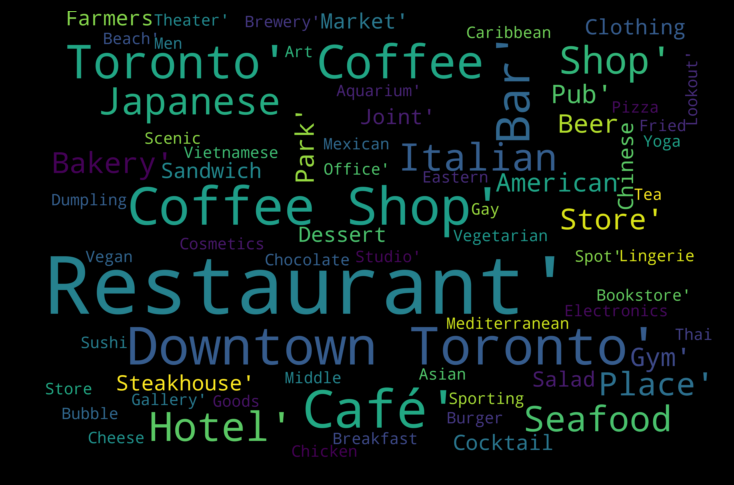

In [65]:
text = CLUSTER_2_TEXT
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### CLUSTER #3: CHRISTIE CLUSTER
Like the Airport Cluster and Parks and Rec Cluster the reasoning for the title of the Christie Cluster is fairly obvious. Due to the limited number of cases/neighbourhoods being clustered in Toronto's downtown core, as well as practical and geographical reason, 3 clusters contain only one neighbourhood. The reason for Christie's outlier status is less obvious than it that for Rosedale (Cluster #1) or the Airport (#Cluster 4). From the merged dataframe and the word cloud below we can see that Christie Cluster stands out somewhat from the Metro Cluster (Cluster #2) in that it appears to be geared more towards middle-class or family living. The most common venue is grocery store, "Baby Store' is the 9th most common and only appears in Christie's top 10 values, 'Candy Store' is the 5th most common venue, and 'Park' is 3rd. It would appear Christie leans more towards catering to family living than it is to the Metropolitan experience such as the case with Metro Cluster. The Word Cloud supports this as well, showcasing words such as 'Grocery', 'Baby', 'Candy' and 'Park' in sharp contrast to the stronger emphasis on Cafes and Restauraunts present in the Mtero CLuster word cloud.

In [66]:
CLUSTER_3 = DT_TO_merged.loc[DT_TO_merged['Cluster Labels'] == 2, DT_TO_merged.columns[[1] + list(range(5, DT_TO_merged.shape[1]))]]
CLUSTER_3

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Downtown Toronto,2,Grocery Store,Café,Park,Italian Restaurant,Candy Store,Coffee Shop,Diner,Nightclub,Baby Store,Restaurant


#### GATHER DESCRIPTIVE STATS INCLUDING CATEGORICAL VALUES FOR THE CLUSTER

In [68]:
CLUSTER_3.describe(include = 'all')

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,1,1.0,1,1,1,1,1,1,1,1,1,1
unique,1,NaN,1,1,1,1,1,1,1,1,1,1
top,Downtown Toronto,NaN,Grocery Store,Café,Park,Italian Restaurant,Candy Store,Coffee Shop,Diner,Nightclub,Baby Store,Restaurant
freq,1,NaN,1,1,1,1,1,1,1,1,1,1
mean,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### VISUALIZE CLUSTER WITH A WORDCLOUD

In [69]:
CLUSTER_3_TEXT = CLUSTER_3.values.tolist()
CLUSTER_3_TEXT

[['Downtown Toronto',
  2,
  'Grocery Store',
  'Café',
  'Park',
  'Italian Restaurant',
  'Candy Store',
  'Coffee Shop',
  'Diner',
  'Nightclub',
  'Baby Store',
  'Restaurant']]

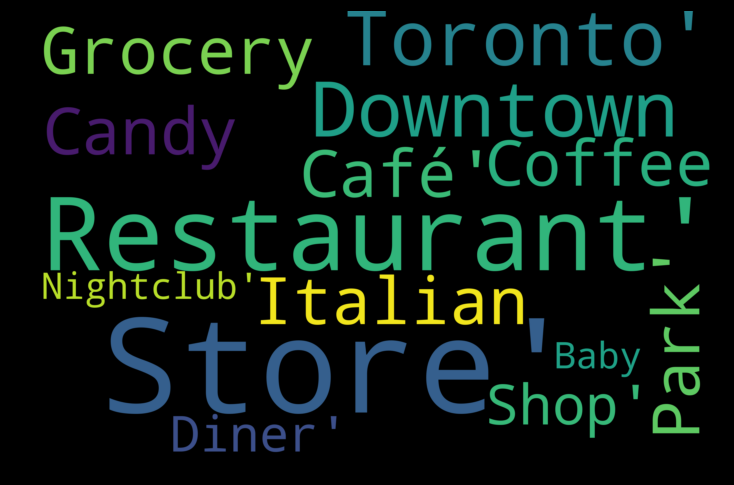

In [70]:
text = CLUSTER_3_TEXT
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### CLUSTER #4: AIRPORT CLUSTER
The reasoning for the title of this cluster is fairly obvious. Unlike the other clusters which tend to be dominated by venues centered around dining and cooffee, we can see from the merged dataframe for this cluster that 4 of the 5 most common values are related to airports or aircraft. Bars are the 4th most common value, which is also to be expected as bars are more or less ubiquitous in and around airports.
This cluster contains a solitary outlier neighbourhood which is to be expected as airports tend to be somewhat monolithic in major cities such as toronto.In future analysis it would likely be prudent to remove this neighbourhood from the analysis, but this would depend on the nature/purpose of said analysis.
Due to there only being one neighbourhood (row/case) in the cluster the descriptive statistics and word cloud aren't very informative, however, they are included for both consistency and for practice.

In [72]:
CLUSTER_4 = DT_TO_merged.loc[DT_TO_merged['Cluster Labels'] == 3, DT_TO_merged.columns[[1] + list(range(5, DT_TO_merged.shape[1]))]]
CLUSTER_4

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Downtown Toronto,3,Airport Service,Airport Terminal,Airport,Bar,Plane,Rental Car Location,Sculpture Garden,Boutique,Boat or Ferry,Coffee Shop


#### GATHER DESCRIPTIVE STATS INCLUDING CATEGORICAL VALUES FOR THE CLUSTER

In [73]:
CLUSTER_4.describe(include = 'all')

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,1,1.0,1,1,1,1,1,1,1,1,1,1
unique,1,NaN,1,1,1,1,1,1,1,1,1,1
top,Downtown Toronto,NaN,Airport Service,Airport Terminal,Airport,Bar,Plane,Rental Car Location,Sculpture Garden,Boutique,Boat or Ferry,Coffee Shop
freq,1,NaN,1,1,1,1,1,1,1,1,1,1
mean,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### VISUALIZE CLUSTER WITH A WORDCLOUD

In [76]:
CLUSTER_4_TEXT = CLUSTER_4.values.tolist()
CLUSTER_4_TEXT

[['Downtown Toronto',
  3,
  'Airport Service',
  'Airport Terminal',
  'Airport',
  'Bar',
  'Plane',
  'Rental Car Location',
  'Sculpture Garden',
  'Boutique',
  'Boat or Ferry',
  'Coffee Shop']]

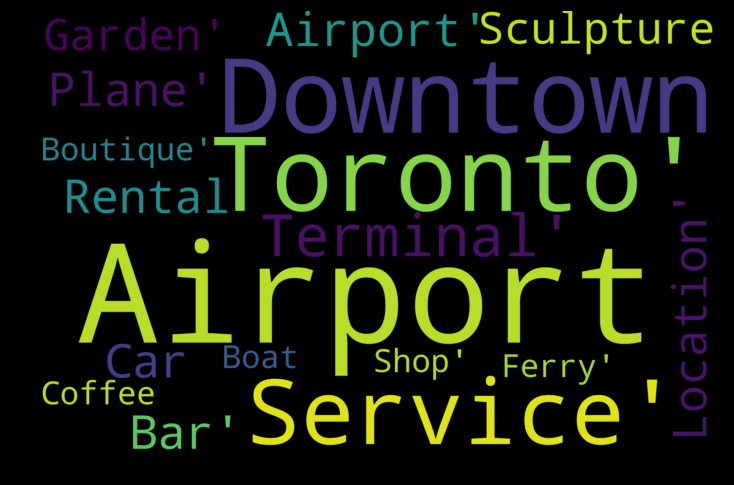

In [77]:
text = CLUSTER_4_TEXT
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### CLUSTER #5: University Cluster
University Cluster, unlike other clusters, is titled less according to it's constituent venues than it is according to it's geographical proximity to the University of Toronto. It is somewhat difficult to distinguish it from the Metro Cluster in that it tends towards venues related to coffee and eating, however, we can see a difference in the types of food oriented venues highlighted. We can see venues that one could assume to be more closely associated with student life, these being Smoothie SHops, Burger Joints, Sandwich Shops, and a Poke Restaurant. The types of venues and results of the Word Cloud are far less diverse than that for the Metro Cluster (Cluster #2), but this would be expected as venues in and around a university are, again, less geared towards entertainment and lifestyle than they are towards accomodating the needs of students and their time/budget constraints. 

In [78]:
CLUSTER_5 = DT_TO_merged.loc[DT_TO_merged['Cluster Labels'] == 4, DT_TO_merged.columns[[1] + list(range(5, DT_TO_merged.shape[1]))]]
CLUSTER_5

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Downtown Toronto,4,Coffee Shop,Yoga Studio,Sandwich Place,Smoothie Shop,Italian Restaurant,Diner,Portuguese Restaurant,Chinese Restaurant,Bar,Bank
5,Downtown Toronto,4,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint,Japanese Restaurant,Salad Place,Bubble Tea Shop,Poke Place,Portuguese Restaurant


#### GATHER DESCRIPTIVE STATS INCLUDING CATEGORICAL VALUES FOR THE CLUSTER

In [79]:
CLUSTER_5.describe(include = 'all')

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,2,2.0,2,2,2,2,2,2,2,2,2,2
unique,1,NaN,1,2,1,2,2,2,2,2,2,2
top,Downtown Toronto,NaN,Coffee Shop,Yoga Studio,Sandwich Place,Café,Italian Restaurant,Japanese Restaurant,Salad Place,Bubble Tea Shop,Poke Place,Portuguese Restaurant
freq,2,NaN,2,1,2,1,1,1,1,1,1,1
mean,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### VISUALIZE CLUSTER WITH A WORDCLOUD

In [80]:
CLUSTER_5_TEXT = CLUSTER_5.values.tolist()
CLUSTER_5_TEXT

[['Downtown Toronto',
  4,
  'Coffee Shop',
  'Yoga Studio',
  'Sandwich Place',
  'Smoothie Shop',
  'Italian Restaurant',
  'Diner',
  'Portuguese Restaurant',
  'Chinese Restaurant',
  'Bar',
  'Bank'],
 ['Downtown Toronto',
  4,
  'Coffee Shop',
  'Italian Restaurant',
  'Sandwich Place',
  'Café',
  'Burger Joint',
  'Japanese Restaurant',
  'Salad Place',
  'Bubble Tea Shop',
  'Poke Place',
  'Portuguese Restaurant']]

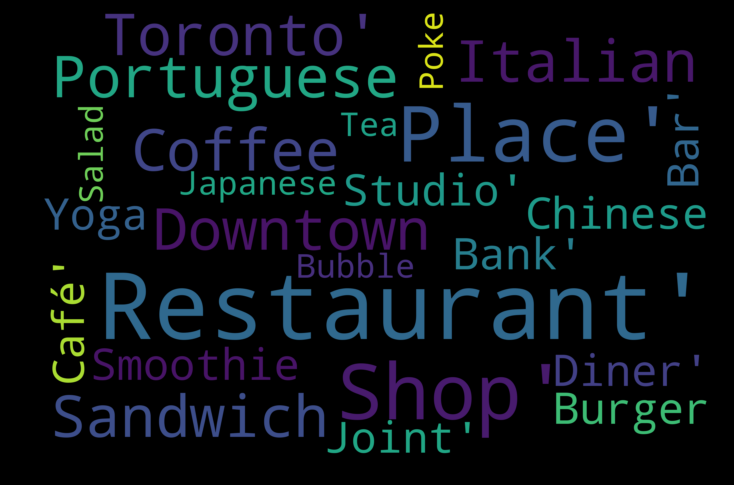

In [81]:
text = CLUSTER_5_TEXT
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# REFERENCE CODE
## PLEASE IGNORE THE CODE BELOW AS IT IS HERE FOR MY OWN FUTURE REFERENCE

def getNearbyVenues(names, latitudes, longitudes, radius=500, DT_LIMIT=500): #Initialize the function
    
    #Now define the function
    venues_list=[] #Initialize list of venues to be updated by the function.
    
    #Build for loop that crates the API Request URL, makes the GET request. and returns only the venues info that we want.
    
    for name, lat, lng in zip(names, latitudes, longitudes): #Initialize the for loop. WHen calling function we use the Downtown Toronto Dataframe
        print(name)
        
        #Create API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            DT_LIMIT)
        
        #Make the GET request much like we did for the neighbourhood of Christie, specifying what to draw from the JSON file
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
        
        return(nearby_venues)